# Confounding Example: Finding causal effects from observed data

Suppose you are given some data with treatment and outcome. Can you determine whether the treatment causes the outcome, or is the correlation purely due to another common cause?

This jupyter notebook is based on the DoWhy tutorial: https://microsoft.github.io/dowhy/example_notebooks/dowhy_confounder_example.html

Here we have made the linear model and the graph explicit.

In [1]:
import numpy as np
import pandas as pd
import dowhy
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn import linear_model
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter
from IPython.display import Image, display

/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Two linear models

Creating the dataset. It is generated from either of two models:
* **Model 1**: Treatment does cause outcome. 
* **Model 2**: Treatment does not cause outcome. All observed correlation is due to a common cause.

In [2]:
def model(num_samples, effect=True, sd_error=1):
    treatment = 'Treatment'
    outcome = 'Outcome'
    common_causes = ['common']
    E1 = np.random.normal(loc=0, scale=sd_error, size=num_samples)
    E2 = np.random.normal(loc=0, scale=sd_error, size=num_samples)
    X = np.random.normal(loc=1, scale=sd_error*2, size=num_samples)
    T = X + E1
    if effect:
        Y = 1 + T + X + E2
    else: 
        Y = 1 + X + E2
    dat = {
        treatment: T,
        outcome: Y,
        common_causes[0]: X 
    }
    data = pd.DataFrame(data=dat)
    ret_dict = {
        "df": data,
        "treatment_name": treatment,
        "outcome_name": outcome,
        "common_causes_names": common_causes,
        "instrument_names": None,
        "dot_graph": None,
        "gml_graph": None,
        "ate": None,
    }
    return ret_dict

In [3]:
#Model1:
data_dict = model(10000, effect=False, sd_error=0.2)    
df = data_dict['df']  
df

,Treatment,Outcome,common
0,0.719802,1.548032,0.610514
1,0.585655,1.503280,0.776089
2,0.051558,1.164839,0.274737
3,0.502674,1.549806,0.389772
4,1.035748,1.791152,0.868527
5,1.708381,2.378310,1.416140
6,0.590156,2.016249,0.756973
7,1.426901,1.858046,1.249063
8,0.904934,1.603984,0.463760
9,0.492027,1.085579,0.544941


In [4]:
#Model2:
#data_dict = model(10000, effect=False, sd_error=0.2)    
#df = data_dict['df']  

# Using DoWhy to resolve the mystery: *Does Treatment cause Outcome variable?*
## STEP 1: Model the problem as a causal graph
Initializing the causal model.

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Treatment'] on outcome ['Outcome']


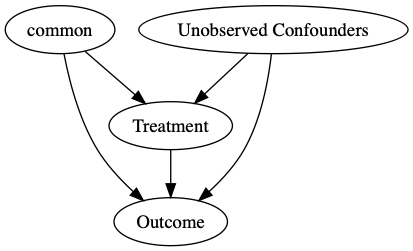

In [5]:
model= CausalModel(
        data=df,
        treatment=data_dict["treatment_name"],
        outcome=data_dict["outcome_name"],
        common_causes=data_dict["common_causes_names"],
        instruments=data_dict["instrument_names"],
        graph="""graph[directed 1 node[id "common" label "common"]
                    node[id "Treatment" label "Treatment"]
                    node[id "Outcome" label "Outcome"]
                    node[id "Unobserved Confounders" label "Unobserved Confounders"]
                    edge[source "common" target "Treatment"]
                    edge[source "common" target "Outcome"]
                    edge[source "Treatment" target "Outcome"]
                    edge[source "Unobserved Confounders" target "Treatment"]
                    edge[source "Unobserved Confounders" target "Outcome"]]"""
        )
model.view_model()
display(Image(filename="causal_model.png"))

## STEP 2: Identify causal effect using properties of the formal causal graph
Identify the causal effect using properties of the causal graph.


In [ ]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Unobserved Confounders', 'common']


## STEP 3: Estimate the causal effect

Once we have the identified estimand, can use any statistical method to estimate the causal effect. 

Let's use Linear Regression for simplicity.

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+common


Causal Estimate is 0.9877190253114896


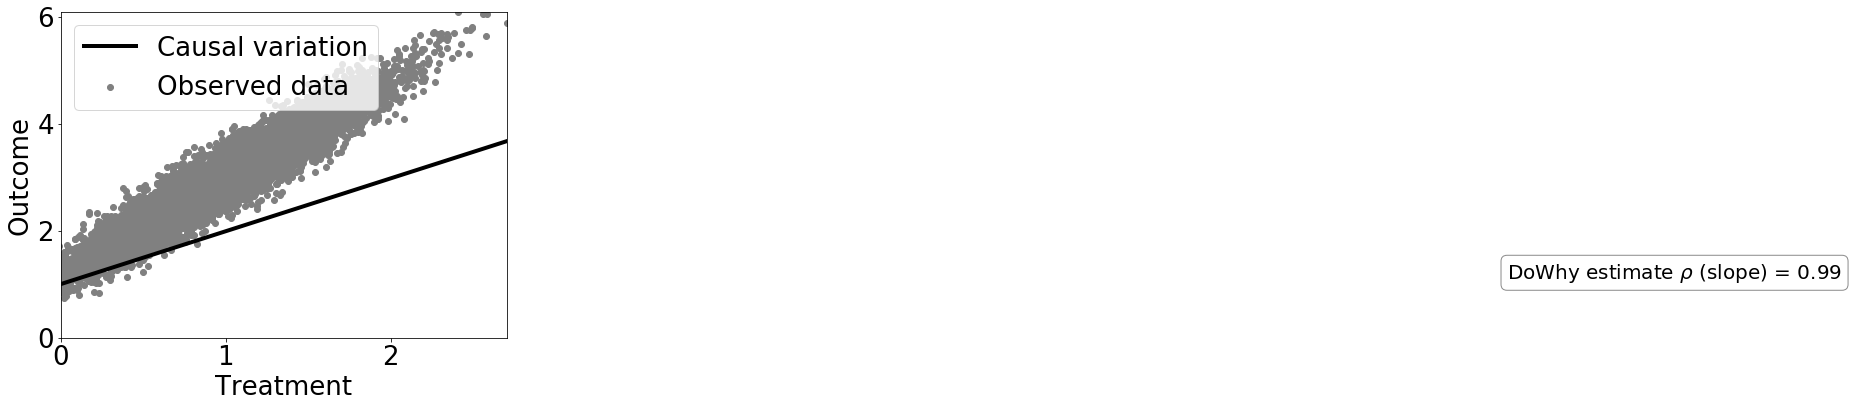

In [29]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

## STEP 4: Refuting the estimate (Sensitivity Analysis) 

### Adding a random common cause variable

In [30]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+common+w_random


Refute: Add a Random Common Cause
Estimated effect:(0.9877190253114896,)
New effect:(0.9877241830467902,)



### Replacing treatment with a random (placebo) variable

In [20]:
# If placebo_type is "permute", then the original treatment values are permuted by row
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+common


Refute: Use a Placebo Treatment
Estimated effect:(0.010085749159828739,)
New effect:(-0.0004990755897924526,)



### Removing a random subset of the data

In [21]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.8)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+common


Refute: Use a subset of data
Estimated effect:(0.010085749159828739,)
New effect:(0.009149469524865506,)

